# Arrival Rate vs Latency Analysis

This notebook analyzes the relationship between arrival rate and average latency in the MBPP testing results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# CSV path
csv_path = "../logs/mbpp_2026-01-24-14-24-23_telemetry.csv"

In [3]:
# Load the data
df = pd.read_csv(csv_path)

# Display basic information
print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total rows: 57

Columns: ['run_id', 'dataset', 'split', 'batch_id', 'item_id', 'record_type', 'task_name', 'reasoning_name', 'decision_method', 'graph_id', 'num_rounds', 'num_agents', 'agent_roles_json', 'agent_llms_json', 'role_llm_map_json', 'workflow_latency_seconds', 'llm_elapsed_seconds', 'node_id', 'node_name', 'role_name', 'llm_name', 'is_decision_node', 'round_idx', 'attempts', 'success', 'error', 'ts_start', 'ts_end', 'duration_sec', 'cost_delta', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'output_text', 'router_log_prob', 'router_task_probs_json', 'router_agent_num_pred', 'utility', 'quality_is_correct', 'quality_pred', 'quality_gold', 'quality_feedback', 'quality_state_json', 'eval_duration_sec', 'arrival_rate', 'arrival_pattern']

First few rows:


,run_id,dataset,split,batch_id,item_id,record_type,task_name,reasoning_name,decision_method,graph_id,...,router_agent_num_pred,utility,quality_is_correct,quality_pred,quality_gold,quality_feedback,quality_state_json,eval_duration_sec,arrival_rate,arrival_pattern
0,2026-01-24-14-24-23,mbpp,test,0.0,12,workflow,Code,CoT,FinalRefer,7UFm,...,2.821062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2026-01-24-14-24-23,mbpp,test,0.0,12,node,Code,CoT,FinalRefer,7UFm,...,2.821062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2026-01-24-14-24-23,mbpp,test,0.0,12,node,Code,CoT,FinalRefer,7UFm,...,2.821062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2026-01-24-14-24-23,mbpp,test,0.0,12,node,Code,CoT,FinalRefer,7UFm,...,2.821062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2026-01-24-14-24-23,mbpp,test,0.0,12,node,Code,CoT,FinalRefer,7UFm,...,2.821062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Filter for quality records only (these contain the arrival_rate and workflow metrics)
quality_df = df[df['record_type'] == 'quality'].copy()

print(f"Quality records: {len(quality_df)}")
print(f"\nArrival rates in data: {quality_df['arrival_rate'].unique()}")
print(f"\nArrival pattern: {quality_df['arrival_pattern'].unique()}")

Quality records: 9

Arrival rates in data: [1. 2. 3.]

Arrival pattern: ['poisson']


In [5]:
# Calculate average latency per arrival rate
latency_by_rate = quality_df.groupby('arrival_rate')['workflow_latency_seconds'].agg(['mean', 'std', 'count'])
latency_by_rate = latency_by_rate.reset_index()

print("Average latency by arrival rate:")
print(latency_by_rate)

Average latency by arrival rate:
   arrival_rate       mean       std  count
0           1.0  16.603829  7.871864      3
1           2.0  14.616014  9.453319      3
2           3.0   7.971112  6.130856      3


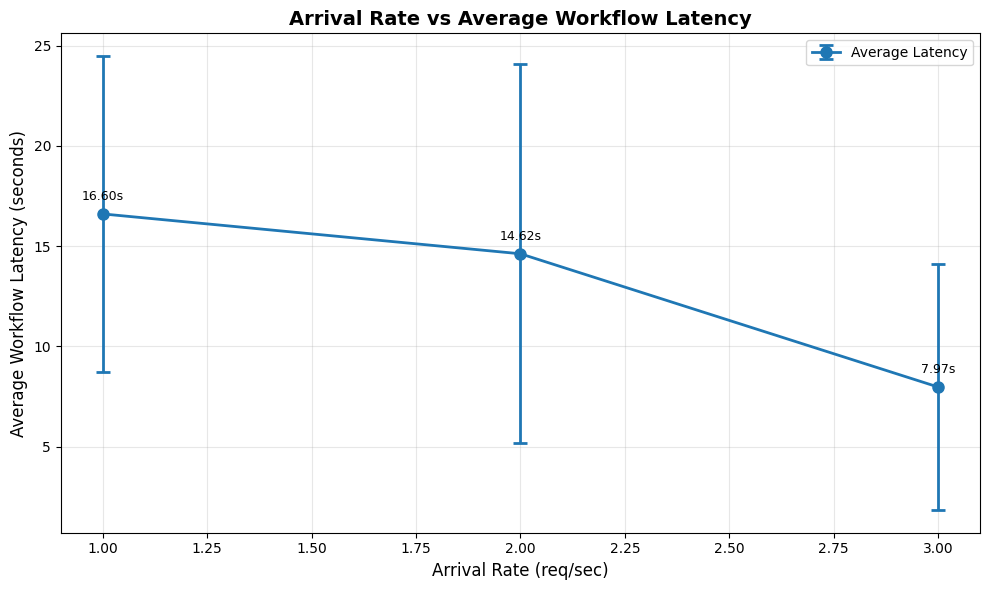

In [6]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot average latency with error bars (standard deviation)
plt.errorbar(latency_by_rate['arrival_rate'], 
             latency_by_rate['mean'],
             yerr=latency_by_rate['std'],
             marker='o', 
             markersize=8,
             linewidth=2,
             capsize=5,
             capthick=2,
             label='Average Latency')

plt.xlabel('Arrival Rate (req/sec)', fontsize=12)
plt.ylabel('Average Workflow Latency (seconds)', fontsize=12)
plt.title('Arrival Rate vs Average Workflow Latency', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add value labels on the points
for idx, row in latency_by_rate.iterrows():
    plt.annotate(f"{row['mean']:.2f}s", 
                 (row['arrival_rate'], row['mean']),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=9)

plt.tight_layout()
plt.show()

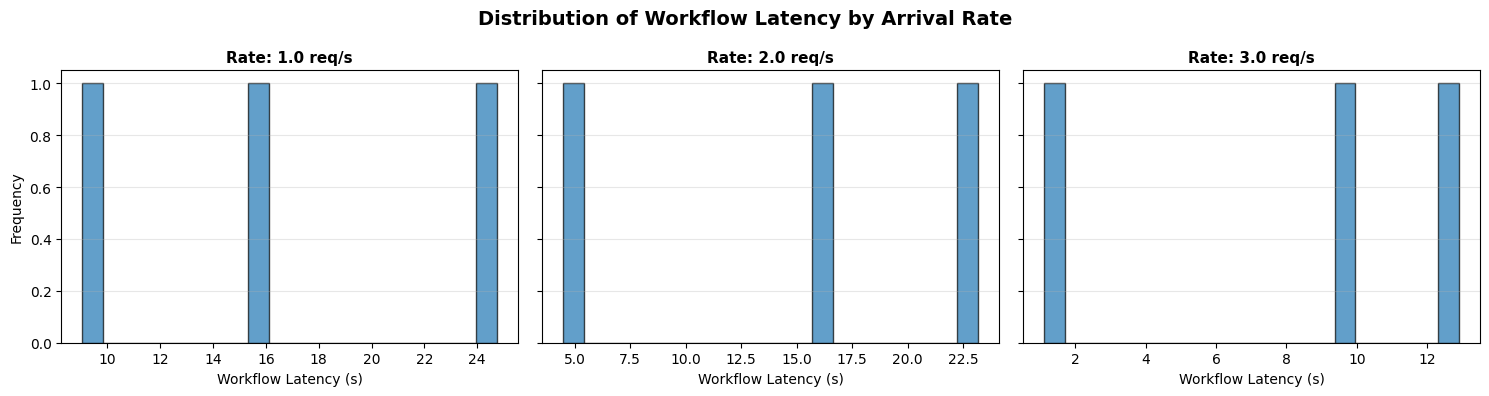

In [7]:
# Additional analysis: Show distribution of latencies per arrival rate
fig, axes = plt.subplots(1, len(latency_by_rate), figsize=(15, 4), sharey=True)

if len(latency_by_rate) == 1:
    axes = [axes]

for idx, (ax, rate) in enumerate(zip(axes, latency_by_rate['arrival_rate'])):
    rate_data = quality_df[quality_df['arrival_rate'] == rate]['workflow_latency_seconds']
    ax.hist(rate_data, bins=20, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Workflow Latency (s)', fontsize=10)
    ax.set_title(f'Rate: {rate} req/s', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

axes[0].set_ylabel('Frequency', fontsize=10)
fig.suptitle('Distribution of Workflow Latency by Arrival Rate', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()